The problem of predicting the number of crimes based on the historical information is not new. For example, we can check the paper from Safro's lab "Spatio-temporal prediction of crimes using network analytic approach" that is dealing with a very similar data from the Chicago area. 
https://arxiv.org/pdf/1808.06241.pdf

This and several other studies conclude that the first key to succeed in such a prediction is fusing several other data sources that are in the first glance not directly related to crimes but can be helpful in the description of quality of life. For example, in this paper they take into account the quality of public schools (including the average student grades), information about public libraries, and 311 service calls. It is also clear that many more publicly available data can affect the prediction, e.g., number of police officers, their salary, planned construction, changes in the office of mayor, governor, elections, and many more. A lot of such information can be taken at city portals like https://data.cityofchicago.org/.

The second key to succeed in this prediction is to develop advanced similarity measure that will take into account only those neighborhoods/communities/areas that are most similar to the one that we are going to predict. In other words, we don't need to necessarily rely on the information taken over the whole NY city. Instead, they achieve high quality prediction based on only several most similar neighborhoods wheras the similarity was based on massively fused early mentioned types of information. In particular, their approach for the similarity measure was random walk based similarity on a multi-layer network with different types of nodes such as communities, police stations, types of crimes, service calls, libraries, etc. For the purpose of the commercial product, the metagraph (see Fig. 2 in https://arxiv.org/pdf/1808.06241.pdf) structure to compute similarities should be much more complicated. Alternatively, one can also use modern low dimensional representation learning.

After implementing these two approaches and training appropriate measures, one can use almost any standard learning approach, depending on the required level of interpretability. For example, using ARIMA, SVR or simple polynomial regression like in that paper can provide an insight on the features that affect the prediction. If interpretability is not one of the goals then deep learning can be applied as well.

Understanding and fusing several data types from various sources requires quite a lot of time and resources, so taking into account a short time for this assignment I decided to work only with the proided data set deliberately limiting myself to a single type of crime.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from haversine import haversine

TARGET_ADDR_PCT_CD = 44
TARGET_KY_CD = 107

TARGET_LAT_LON = (40.8369697,-73.9200051)

LAT_LON_DIFF = [haversine((40, -70), (41, -70)), haversine((40, -70), (40, -71))]

Lets load the data. 

1. Due to memory limitation we'll truncate all redundunt or irrelivant data. 
2. There are 0.4% of rows missed data, we'll drop them.

In [2]:
usecols=['ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'JURISDICTION_CODE', 'Latitude', 'Longitude']
df = pd.read_csv('NYPD_Complaint_Data_Historic.csv', parse_dates=['RPT_DT'], usecols=usecols)

# drop NA
df = df[df.isna().any(axis=1) == False]
df.ADDR_PCT_CD = df.ADDR_PCT_CD.astype('int')

# create quarter column
year = df['RPT_DT'].dt.year.tolist()
quarter = df['RPT_DT'].dt.quarter.tolist()
df['year'] = year
df['quarter'] = quarter
df['Q'] = ['%d-%d' % (y, q) for y,q in zip(year, quarter)]

# dummy column, to easy 'group by' manipulations
df['I'] = 1

# create precint related coordinates and drop outliers
df['DY'] = (df.Latitude - TARGET_LAT_LON[0])*LAT_LON_DIFF[0]
df['DX'] = (df.Longitude - TARGET_LAT_LON[1])*LAT_LON_DIFF[1]

df44 = df[df.ADDR_PCT_CD == TARGET_ADDR_PCT_CD]
df44 = df44[df44.DX ** 2 + df44.DY ** 2 < 25] 


Then we see if we as human beings can observe any trands in the data.

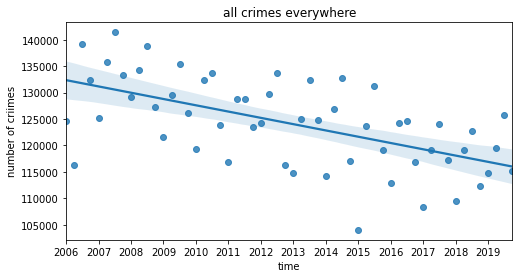

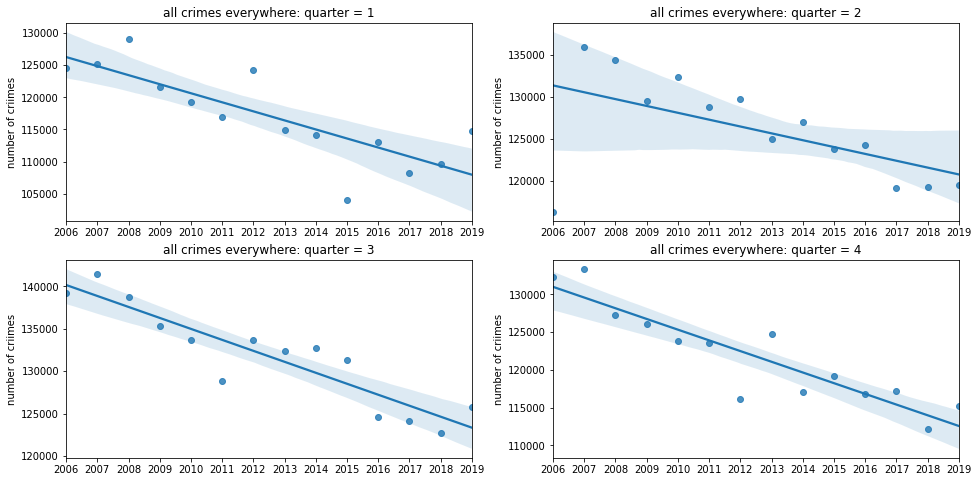

----------------------------------------------------------------------------------------


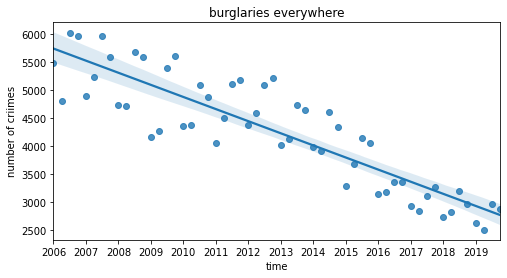

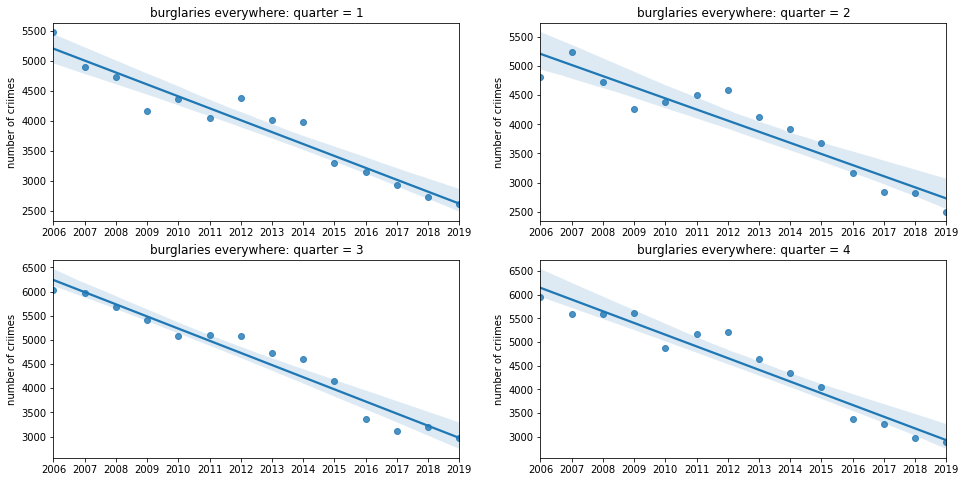

----------------------------------------------------------------------------------------


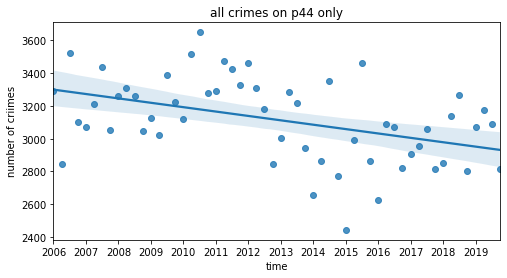

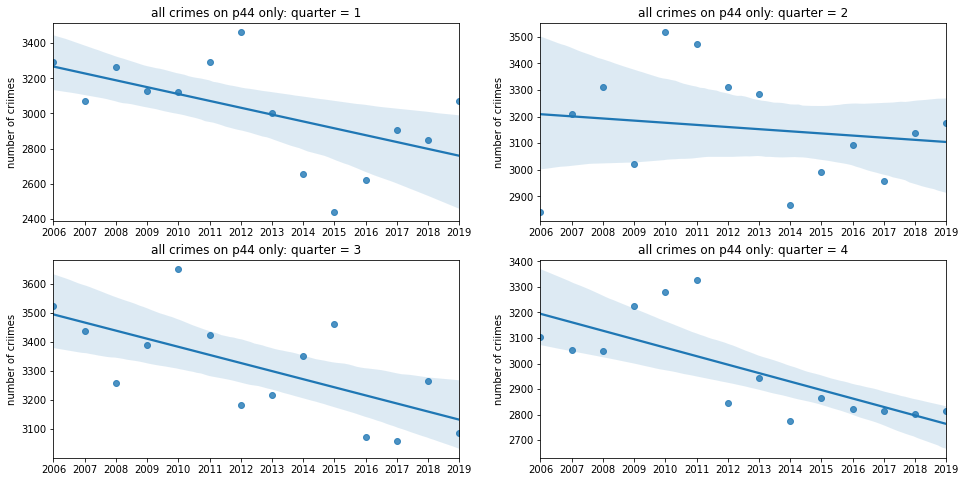

----------------------------------------------------------------------------------------


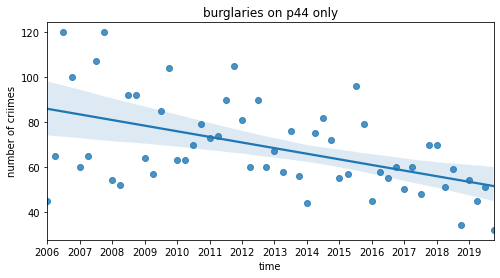

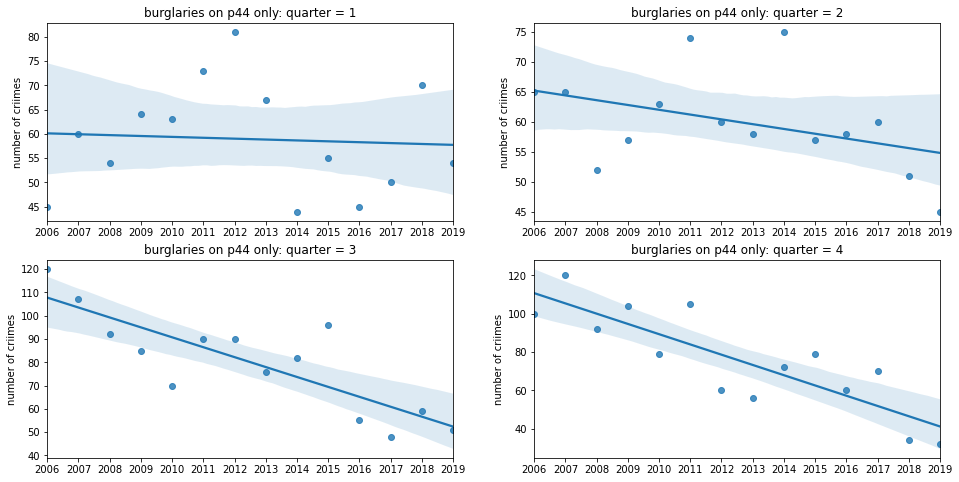

----------------------------------------------------------------------------------------


In [3]:
def plot_dynamics(df, title):
    plt.figure(figsize=(8, 4))
    data = df[['Q', 'I', 'year']].groupby(['Q', 'year']).count().reset_index().sort_values(by='Q')
    sns.regplot(x='index', y='I', data=data.reset_index())
    plt.title(title)
    plt.xticks(np.arange(0, len(data.year), 4), data.year.values[::4])
    plt.xlabel('time')
    plt.ylabel('number of criimes')
    plt.show()
    
def plot_dynamics_quarter(df, title):
    plt.figure(figsize=(16,8))
    for q in range(1, 5):
        plt.subplot(2,2, q)
        data = df[df.RPT_DT.dt.quarter == q][['Q', 'I', 'year']].groupby(['Q', 'year']).count().reset_index().sort_values(by='Q').reset_index()
        sns.regplot(x='index', y='I', data=data)
        plt.title('%s: quarter = %d' % (title, q))
        plt.xticks(np.arange(len(data.year)), data.year.values)
        plt.xlabel('')
        plt.ylabel('number of criimes')
    plt.show()

plot_dynamics(df, 'all crimes everywhere')
plot_dynamics_quarter(df, 'all crimes everywhere')
print('----------------------------------------------------------------------------------------')

plot_dynamics(df[df.KY_CD == TARGET_KY_CD], 'burglaries everywhere')
plot_dynamics_quarter(df[df.KY_CD == TARGET_KY_CD], 'burglaries everywhere')
print('----------------------------------------------------------------------------------------')

plot_dynamics(df[(df.ADDR_PCT_CD == TARGET_ADDR_PCT_CD)], 'all crimes on p44 only')    
plot_dynamics_quarter(df[(df.ADDR_PCT_CD == TARGET_ADDR_PCT_CD)], 'all crimes on p44 only')    
print('----------------------------------------------------------------------------------------')

plot_dynamics(df[(df.KY_CD == TARGET_KY_CD) & (df.ADDR_PCT_CD == TARGET_ADDR_PCT_CD)], 'burglaries on p44 only')    
plot_dynamics_quarter(df[(df.KY_CD == TARGET_KY_CD) & (df.ADDR_PCT_CD == TARGET_ADDR_PCT_CD)], 'burglaries on p44 only')    
print('----------------------------------------------------------------------------------------')


So, looking at the entire NY, we observe very clear trands in all crimes, as well as in burglaries only.

In particular, we also observe а bold seasonality effect. Crimes depend on seasons which is also confirmed in the relevant literature such as "Crime seasonality and its variations across space" that confirms that all crime types exhibit seasonality but the pattern varies by crime types, and simply aggregating various types of crime data is problematic. https://www.sciencedirect.com/science/article/abs/pii/S0143622813001410.

Based on this observation we conclude that for the sake of this exercise we can predict future number of crimes using ARIMA, or just usinig simple linear regression, but this will be done separately per quarter. 

When we look at precinct 44 only, we observe a still slightly decreasing trand. However the data is more noisy (due to small numbers). The short cut approach that I take is predicting burglaries in the entire NY, but then multiply it by the expected fraction computed for precint 44 which will give us more stable results in the presence of small numbers.

Correlation:  0.7037739589213344
Expected fraction is  0.016309106213306595


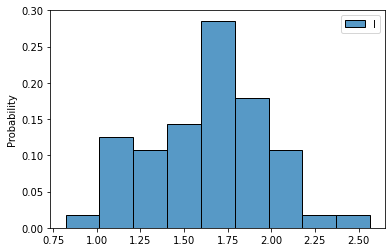

In [6]:
burg_all = df[df.KY_CD == TARGET_KY_CD][['Q', 'I']].groupby('Q').count()
burg_44 = df[(df.KY_CD == TARGET_KY_CD) & (df.ADDR_PCT_CD == TARGET_ADDR_PCT_CD)][['Q', 'I']].groupby('Q').count()
sns.histplot((burg_44 / burg_all)*100, stat='probability')
fraction_44 = (burg_44 / burg_all).values.mean()
print('Correlation: ', np.corrcoef(burg_44['I'].values, burg_all['I'].values)[0,1])
print('Expected fraction is ', fraction_44)

In [5]:
from sklearn.linear_model import LinearRegression

def get_forecast(df, y, q):
    data = df[(df.year < y) & (df.quarter == q)]
    Y = data[['Q', 'I']].groupby('Q').count().sort_values('Q')['I'].values.reshape(-1, 1)
    X = np.arange(len(Y)).reshape(-1, 1).reshape(-1, 1)
    lr = LinearRegression().fit(X, Y)
    p = lr.predict(X[-1:,:] + 1)
    return p[0][0]

def get_gt(df, y, q):
    return df[(df.year == y) & (df.quarter == q)]['I'].count()

def calc_error(pred, gt):
    return (pred - gt)/gt

pred_18 = get_forecast(df[df.KY_CD == TARGET_KY_CD], 2018, 1) * fraction_44
gt_18   = get_gt(df[(df.KY_CD == TARGET_KY_CD) & (df.ADDR_PCT_CD == TARGET_ADDR_PCT_CD)], 2018, 1)
print('Year 2018: pred is %d, gt is %d, err is %.2f%%' % (pred_18, gt_18, calc_error(pred_18, gt_18)*100))

pred_20 = get_forecast(df[df.KY_CD == TARGET_KY_CD], 2020, 1) * fraction_44
print('Year 2020: pred is %d' % pred_20)


Year 2018: pred is 46, gt is 70, err is -33.40%
Year 2020: pred is 39


Overall, prediction a safe place to live is more complecated than just looking at the crime data. One has to fuse many different information sources including resident satisfactory surveys, schools data (that is traditionally highly indicative in the US), financila data of the state and city, current state of political situation and type of the administration. All this requires a lot of heterogeneous data fusion to make it commerical grade product. Moreover, it will certainly depend on the available finances. I believe that for different levels of housing, different patterns will be observed in the prediction. 

For a simple short cut approach, one can build a density map of future predicted crimes and select an address with minimal density. The 'classical' approach for this is KDE. Namely, to build a 2D histogram and apply Gaussian smoothing filter. This can be done in case the observed area consists of more or less homogeneous neighborhoods. The problem is that in the USA, the neighborhoods are extremely heterogeneous, e.g., the best areas such as University of Chicago and Hyde Park are within one block from the most dangerous and criminal areas but in this case the borders between neghborhoods are very bold and smoothers should not take into account extremely high difference if observed for some of the paris of norders.
